# Premier test de postérization de la couleur de l'image

Utilisation de la sgmentation pour donner un coté peinture à l'huile

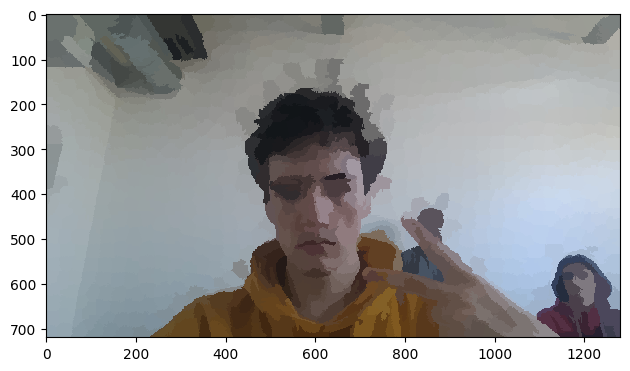

In [4]:
from skimage import data, segmentation, color
from skimage import graph
from skimage import io
from matplotlib import pyplot as plt
from skimage import util

img = util.img_as_float(io.imread("resources/images/test_1.jpg"))



img_shape = img.shape

lenght_average = (img_shape[0] + img_shape[1])/2

labels1 = segmentation.slic(img, compactness=2, n_segments=lenght_average, start_label=1)
img_posterized = color.label2rgb(labels1, img, kind='avg', bg_label=0)



io.imshow(img_posterized)

# Tweeks concernant la couleur

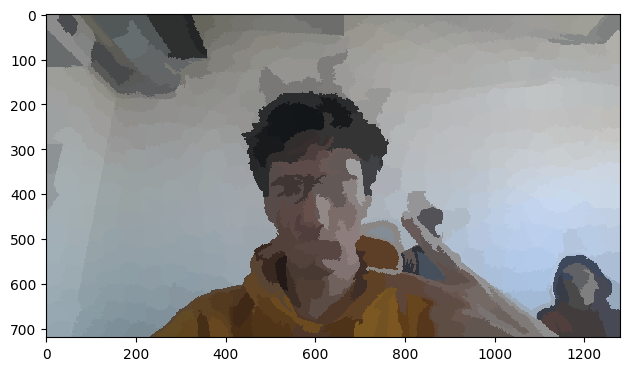

In [5]:
from skimage import filters

filtered_img = filters.median(img)

labels1 = segmentation.slic(img, compactness=2, n_segments=lenght_average/2, start_label=1)
posterized_image = color.label2rgb(labels1, filtered_img, kind='avg', bg_label=0)


io.imshow(posterized_image)

# Option en utilisant un filtre de type posterize sur la luminosité avec un flout gaussin en teinte et saturation pour donner un effet acrylique

In [6]:
from skimage import util
from skimage import color
import numpy as np




img_denoised = filters.median(img)

blured_img = filters.gaussian(img_denoised, sigma = lenght_average*0.01)

img_hsv = color.rgb2hsv(blured_img)

blured_img = color.rgb2hsv(blured_img)



#img_hsv[:,:,2] = filters.gaussian(color.rgb2hsv(posterized_image)[:,:,2], sigma = 4)


def my_function(x):
    posterization_steps = 5
    return min(round((x+1/posterization_steps)*posterization_steps)/posterization_steps,1)

gamma = 0.8

img_hsv[:,:,1] = img_hsv[:,:,1]**gamma

img_hsv[:,:,2] = filters.gaussian(img_denoised, sigma = lenght_average*0.004)[:,:,2]**gamma

img_hsv[:,:,2] = np.vectorize(my_function)(img_hsv[:,:,2])

img_hsv[:,:,2] = filters.gaussian(img_hsv[:,:,2]**(1/gamma), sigma = lenght_average*0.0015)[:,:,2]
# img_hsv[:,:,2] = img_hsv[:,:,2]**(1/gamma)

fig = plt.figure(figsize=(15, 8))
for i, c in enumerate(["Teinte", "Saturation", "Valeur"]):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(img_hsv[:,:,i], cmap="gray")
    plt.title(c)
plt.show()

colors = color.hsv2rgb(img_hsv)
io.imshow(colors)

C:\Users\Jame\AppData\Local\Temp\ipykernel_11564\3309131849.py:10: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  blured_img = filters.gaussian(img_denoised, sigma = lenght_average*0.01)
C:\Users\Jame\AppData\Local\Temp\ipykernel_11564\3309131849.py:29: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  img_hsv[:,:,2] = filters.gaussian(img_denoised, sigma = lenght_average*0.004)[:,:,2]**gamma


NameError: name 'contrast_amount' is not defined

## Détection des contour : comparaison Prewitt, Sobel et Canny

Prewitt ....

Sobel est un filtre proposé par Sobel et Feldman en 1968 qui permet de faire de la détection de contour. Ce filtre est composé de deux kernels, l'un pour détecter les gradients horizontaux et l'autre pour détecter les gradien verticaux, `filters.sobel` nous permet de faire les deux en même temps.

Canny est un filtre qui fait de la segmentation par contour. Il très similaire à l'approche par binarisation mais exploite les contours de l'image plutôt que les intensités. Nous utilisons `filters.prewitt`


Pour notre cas Canny semble le mieux


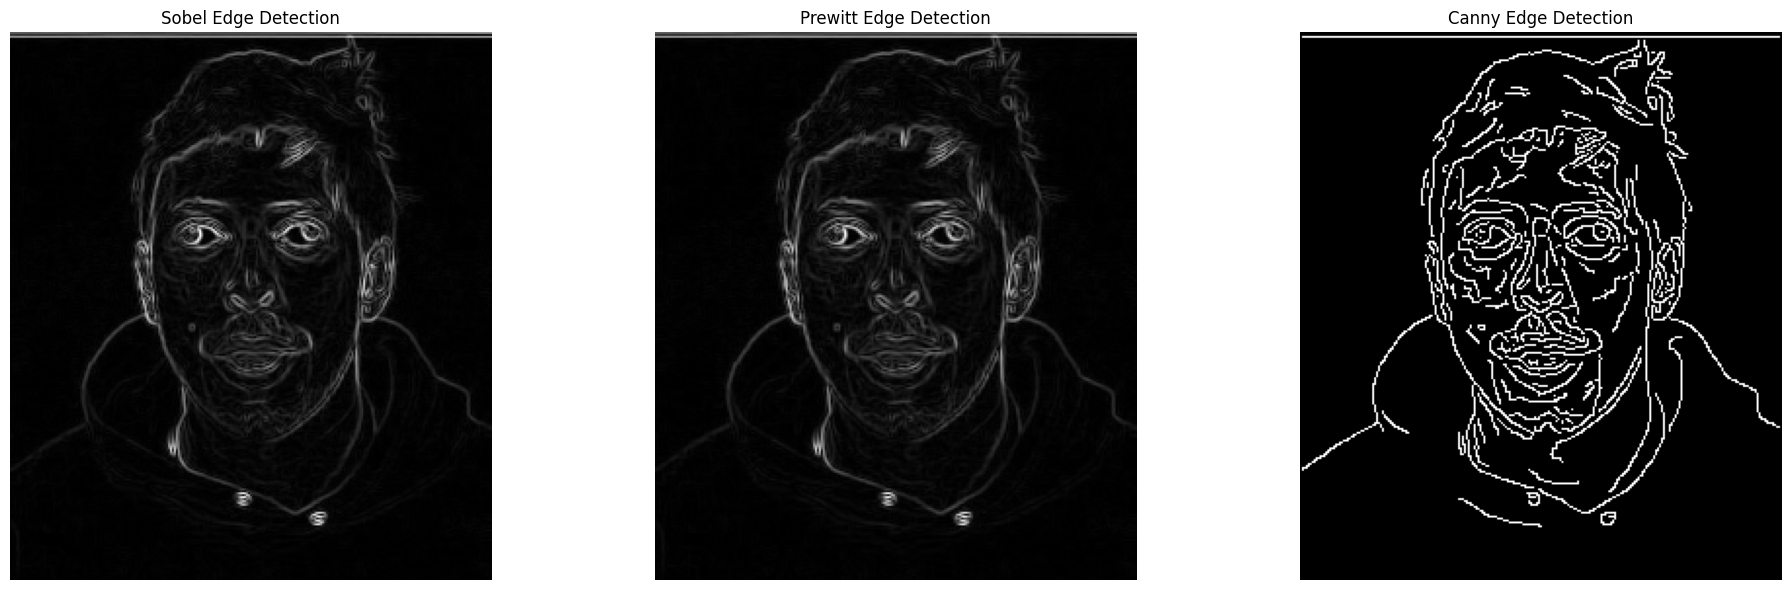

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images
from skimage.util import img_as_float
from skimage import io

from skimage import feature


edge_sobel = filters.sobel(image[:,:,1])
edge_prewitt = filters.prewitt(image[:,:,1])
edge_canny = feature.canny(image[:,:,1])


fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 6))

axes[0].imshow(edge_sobel, cmap="gray")
axes[0].set_title('Sobel Edge Detection')

axes[1].imshow(edge_prewitt, cmap="gray")
axes[1].set_title('Prewitt Edge Detection')

axes[2].imshow(edge_canny, cmap="gray")
axes[2].set_title('Canny Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Method Otsu

Continuons avec le filtre de sobel :

La méthode Otsu consiste à chercher le seuil optimal, c'est-à-dire celui qui minimise la variance intra-classe au sein des pixels blancs et des pixels noirs. Etant donné que notre objectif est de séparer le mieux possible les coutours blancs du reste noir elle est la meilleur solution.

Deplus, nous avons la contraite de la vidéo, il faut donc prendre en compte les changements de luminosité et de couleur. Le seuil d'Otsu est calculé à chaque fois pour être le meilleur seuil, nous n'avons donc plus besoin d'adapter le seuil à chaque frame à la main.

In [ ]:
from skimage import filters

Text(0.5, 1.0, 'Sobel Edge Detection + otsu')

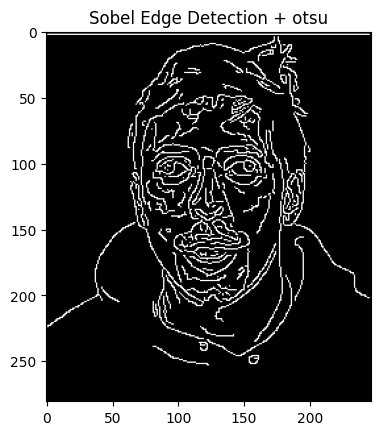

In [ ]:
otsu_threshold = filters.threshold_otsu(edge_sobel)
# image_binarized = edge_sobel > otsu_threshold
image_binarized = edge_canny > otsu_threshold

plt.imshow(image_binarized, cmap="gray")
plt.title("Sobel Edge Detection + otsu")


## Ouverture morphologique

Pour diminuser les artéfactes qui ne font pas partis des contours, nous allons utiliser une ouverture morphologique

In [ ]:
from skimage import morphology

ValueError: operands could not be broadcast together with shapes (720,1280) (281,247) (720,1280) 

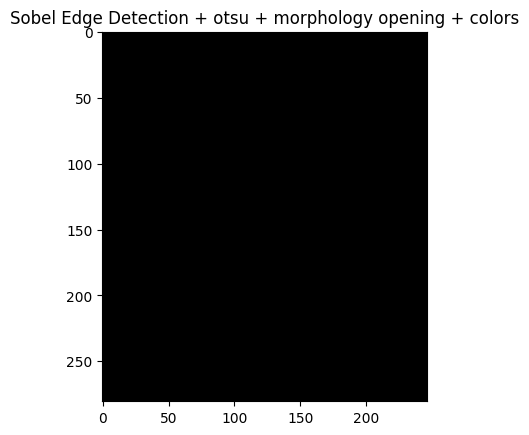

In [ ]:
plt.imshow(morphology.opening(image_binarized), cmap="gray")
plt.title("Sobel Edge Detection + otsu + morphology opening + colors")

from skimage import util

lines = util.invert(image_binarized)

colors[:,:,0] *= lines
colors[:,:,1] *= lines
colors[:,:,2] *= lines
 
plt.imshow(colors, cmap="gray")

